In [1]:
import pandas as pd
import numpy as np
import os,sys,pickle,glob,gc
from tqdm import tqdm

In [ ]:
import findspark
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from tqdm import tqdm
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.set("spark.driver.memory","79g")
conf.set("spark.executor.memory", "89g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","79g")
conf.set("spark.driver.extraJavaOptions","-Xss19999m")
conf.set("spark.driver.extraJavaOptions","-Xms79g")
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.sql.shuffle.partitions",99999)
conf.set("spark.driver.maxResultSize", "30g")
conf.set("spark.sql.debug.maxToStringFields", 199999)
conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",99*1024*1024*1024)
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
sc = SparkContext(conf=conf)
spark.conf.set("spark.sql.execution.arrow.enabled", True)
import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__)

In [239]:
# in_parquet = '../../data_hdd4t/pcap_process/pcap_spark/2020_01_09/中華電信/parquet/2020_01_09_country_session.parquet/'
in_parquet = '../../data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_country_session_withtime_v2.parquet/'
df = pd.read_parquet(in_parquet)
df #所有session
# kf = ks.read_parquet(in_parquet)
# df = kf

,frame.time_epoch,session_lifetime,session_packets,tcp.window_size_value.avg,tcp.window_size_value.max,tcp.srcport,tcp.dstport,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,...,frame.protocols.common,frame.len.sum,city,subdivisions,latitude,longitude,domain,isp,network,country
0,1.578631e+09,0.000287,2,7300.000000,14600.0,56281.0,8080.0,False,False,False,...,eth:ethertype:ip:tcp,114,Kabul,Kabul,34.5167,69.1833,None,Afghan Cyber ISP,103.93.254.0/24,Afghanistan
1,1.578594e+09,0.000305,2,7300.000000,14600.0,54692.0,23.0,False,False,False,...,eth:ethertype:ip:tcp,114,Kabul,Kabul,34.5167,69.1833,None,Etisalat Afghanistan,180.222.136.0/21,Afghanistan
2,1.578601e+09,0.445134,3,741.333333,1200.0,59987.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,168,Kabul,Kabul,34.5167,69.1833,None,Sanzar F Kakar T/A Afghanistan Holding Group,103.71.59.0/24,Afghanistan
3,1.578601e+09,0.384618,3,741.333333,1200.0,59987.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,168,Kabul,Kabul,34.5167,69.1833,None,Sanzar F Kakar T/A Afghanistan Holding Group,103.71.59.0/24,Afghanistan
4,1.578604e+09,68.216591,6,741.333333,1200.0,59987.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,336,Kabul,Kabul,34.5167,69.1833,None,Sanzar F Kakar T/A Afghanistan Holding Group,103.71.59.0/24,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609134,1.578613e+09,8.802488,968,289.412190,29200.0,30646.0,80.0,False,False,False,...,eth:ethertype:ip:tcp,4347006,None,None,NaN,NaN,None,Zwiebelfreunde e.V.,185.220.100.0/24,__HIVE_DEFAULT_PARTITION__
3609135,1.578622e+09,60.012043,783,1643.775223,28960.0,33102.0,80.0,False,False,False,...,eth:ethertype:ip:tcp,1417124,None,None,NaN,NaN,None,MLaB,45.137.184.0/22,__HIVE_DEFAULT_PARTITION__
3609136,1.578641e+09,7.089666,14,6678.571429,29200.0,16594.0,8080.0,False,False,False,...,eth:ethertype:ip:tcp,1079,None,None,NaN,NaN,None,None,None,__HIVE_DEFAULT_PARTITION__
3609137,1.578646e+09,0.000000,1,29200.000000,29200.0,445.0,2133.0,True,False,False,...,eth:ethertype:ip:icmp:ip:tcp,182,None,None,47.0000,8.0000,None,Telia Company,80.91.240.0/20,__HIVE_DEFAULT_PARTITION__


In [ ]:
gc.collect()
df.columns #所有欄位

# 各欄位簡易統計分析

### Session類

In [ ]:
df['session_lifetime'].value_counts() #seconds

In [ ]:
df['session_lifetime'].value_counts().head(60) #seconds

In [ ]:
df['session_packets'].value_counts() #各類別數量

In [ ]:
df['session_packets'].value_counts().head(60)

In [ ]:
df['ip.ttl.avg'].value_counts()

In [ ]:
df['ip.ttl.avg'].value_counts().head(60)

In [ ]:
pd.DataFrame(df['ip.ttl.avg'].value_counts().head(20))

In [ ]:
df['ip.ttl.max'].value_counts()

In [ ]:
df['ip.ttl.max'].value_counts().head(60)

In [ ]:
pd.DataFrame(df['ip.ttl.max'].value_counts().head(20))

In [ ]:
df['frame.len.sum'].value_counts()

In [ ]:
df['frame.len.sum'].value_counts().head(60)

In [ ]:
pd.DataFrame(df['ip.proto'].value_counts())

In [ ]:
pd.DataFrame(df['tcp.flags.ack'].value_counts())

In [ ]:
pd.DataFrame(df['tcp.flags.fin'].value_counts())

In [ ]:
pd.DataFrame(df['tcp.flags.push'].value_counts())

In [ ]:
pd.DataFrame(df['tcp.flags.reset'].value_counts())

In [ ]:
pd.DataFrame(df['tcp.flags.syn'].value_counts())

### 攻擊者方(外部類/source)

In [ ]:
df['tcp.window_size_value.max'].value_counts()

In [ ]:
df['tcp.window_size_value.max'].value_counts().head(60)

In [ ]:
df['tcp.window_size_value.avg'].value_counts() #同session下windows size的平均值都一樣也很特別

In [ ]:
df['tcp.window_size_value.avg'].value_counts().head(60) #很巧的，大家的同session來回之平均windows size大小都一樣

In [ ]:
pd.DataFrame(df['tcp.window_size_value.avg'].value_counts().head(20))

In [ ]:
df['tcp.srcport'].value_counts() # 種類

In [ ]:
df['tcp.srcport'].value_counts().head(60) #分布

In [ ]:
pd.DataFrame(df['tcp.srcport'].value_counts().head(20))

In [ ]:
df['ip.src'].value_counts()

In [ ]:
df['ip.src'].value_counts().head(60)

In [ ]:
df['country'].value_counts()

In [ ]:
df['country'].value_counts().head(60)

In [ ]:
df['city'].value_counts()

In [ ]:
df['city'].value_counts().head(60) #...、重慶、布加拉斯特(羅馬尼亞首都)、鎮江(江蘇省)、杭州、...

In [ ]:
df['subdivisions'].value_counts() 

In [ ]:
df['subdivisions'].value_counts().head(60) #...江蘇省、...、浙江省、...

In [ ]:
df['latitude'].value_counts()

In [ ]:
df['latitude'].value_counts().head(60) #top1=中國城國際區 (Chinatown-International District)
#top2=松江路46巷(台北的住宅區)
#top3=荷蘭阿姆斯特丹IJ灣口
#top4=中國河南省鄭州市

In [ ]:
df['longitude'].value_counts()

In [ ]:
df['longitude'].value_counts().head(60) #top1=美國的中國城國際區 (Chinatown-International District)
#top2=松江路46巷(台北的住宅區)
#top3=荷蘭阿姆斯特丹IJ灣口
#top4=中國河南省鄭州市

In [ ]:
df['domain'].value_counts()

In [ ]:
df['domain'].value_counts().head(60)

In [ ]:
df['isp'].value_counts()

In [ ]:
df['isp'].value_counts().head(60)

In [ ]:
df['network'].value_counts()

In [ ]:
df['network'].value_counts().head(60)

### Honeypot陷阱方(內部類/destination)

In [ ]:
df['tcp.dstport'].value_counts()

In [ ]:
df['tcp.dstport'].value_counts().head(60)

In [ ]:
df['ip.dst'].value_counts()

In [ ]:
df['ip.dst'].value_counts().head(60)

In [ ]:
df['frame.protocols.common'].value_counts()

In [ ]:
df['frame.protocols.common'].value_counts().head(60)

In [185]:
df

,frame.time_epoch,session_lifetime,session_packets,tcp.window_size_value.avg,tcp.window_size_value.max,tcp.srcport,tcp.dstport,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,...,frame.protocols.common,frame.len.sum,city,subdivisions,latitude,longitude,domain,isp,network,country
0,1.578647e+09,0.378300,6,47367.500000,65535.0,1037.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,391,Kabul,Kabul,34.5167,69.1833,io-global.com,Io Global Services Pvt. Limited,125.213.192.0/19,Afghanistan
1,1.578586e+09,0.465374,3,741.333333,1200.0,42326.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,168,Kabul,Kabul,34.5167,69.1833,io-global.com,Io Global Services Pvt. Limited,125.213.192.0/19,Afghanistan
2,1.578588e+09,0.575980,3,741.333333,1200.0,42326.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,168,Kabul,Kabul,34.5167,69.1833,io-global.com,Io Global Services Pvt. Limited,125.213.192.0/19,Afghanistan
3,1.578591e+09,0.546820,3,741.333333,1200.0,42326.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,168,Kabul,Kabul,34.5167,69.1833,io-global.com,Io Global Services Pvt. Limited,125.213.192.0/19,Afghanistan
4,1.578591e+09,0.562986,3,741.333333,1200.0,42326.0,1433.0,False,False,False,...,eth:ethertype:ip:tcp,168,Kabul,Kabul,34.5167,69.1833,io-global.com,Io Global Services Pvt. Limited,125.213.192.0/19,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798595,1.578645e+09,0.003241,2,7200.000000,14400.0,37832.0,80.0,False,False,False,...,eth:ethertype:ip:tcp,134,Harare,Harare,-17.8178,31.0447,zol.co.zw,ZOL Zimbabwe,197.211.192.0/18,Zimbabwe
798596,1.578667e+09,0.606759,18,3558.888889,28960.0,44645.0,80.0,False,False,False,...,eth:ethertype:ip:tcp,8659,Harare,Harare,-17.8178,31.0447,zol.co.zw,ZOL Zimbabwe,197.211.192.0/18,Zimbabwe
798597,1.578587e+09,2.177229,16,6143.437500,29200.0,41688.0,80.0,False,False,False,...,eth:ethertype:ip:tcp,1324,Harare,Harare,-17.8178,31.0447,yoafrica.com,CABS,41.190.56.0/23,Zimbabwe
798598,1.578602e+09,0.000000,1,14600.000000,14600.0,14800.0,80.0,False,False,False,...,eth:ethertype:ip:tcp,54,Harare,Harare,-17.8178,31.0447,yoafrica.com,CABS,41.190.56.0/23,Zimbabwe


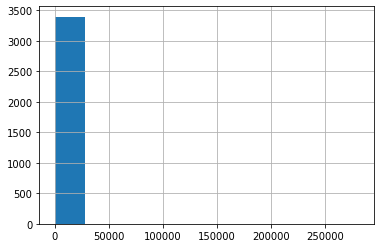

In [238]:
df.session_packets.value_counts().hist(bins=10)

In [189]:
df.columns

Index(['frame.time_epoch', 'session_lifetime', 'session_packets',
       'tcp.window_size_value.avg', 'tcp.window_size_value.max', 'tcp.srcport',
       'tcp.dstport', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'ip.src', 'ip.dst', 'ip.ttl.avg',
       'ip.ttl.max', 'ip.proto', 'frame.protocols.common', 'frame.len.sum',
       'city', 'subdivisions', 'latitude', 'longitude', 'domain', 'isp',
       'network', 'country'],
      dtype='object')

In [228]:
df.loc[770000,'tcp.flags.ack']

False

In [ ]:
df

In [ ]:
df_ori = df.copy()
df = df.dropna()
df = df.reset_index(drop=True)
df

In [120]:
%%time
# df1 = df[['tcp.dstport','domain','ip.src','frame.time_epoch']]
df1 = df[['tcp.dstport','domain','ip.dst','frame.time_epoch']]
df1['tcp.dstport'] = df1['tcp.dstport'].astype(int)
df1 = df1.sort_values('frame.time_epoch')
# df1 = df1[1000:]
df1 = df1.reset_index(drop=True)
temp = df1['frame.time_epoch'].tolist()
del temp[0]
temp.append(0)
df1['frame.time_epoch2'] = pd.Series(temp)
df1['frame.time_epoch2'] = df1['frame.time_epoch2'] - df1['frame.time_epoch']
temp = df1['frame.time_epoch2'].tolist()
del temp[-1]
time_avg = np.mean(temp)
print('###Time interval average:',time_avg,'###')
df1

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Time interval average: 0.10815727067760171 ###
CPU times: user 264 ms, sys: 818 ms, total: 1.08 s
Wall time: 1.1 s


,tcp.dstport,domain,ip.dst,frame.time_epoch,frame.time_epoch2
0,1433,hinet.net,210.242.147.65,1.578585e+09,2.098083e-05
1,1433,hinet.net,210.242.149.113,1.578585e+09,5.888939e-05
2,1433,hinet.net,210.242.148.117,1.578585e+09,2.002716e-05
3,1433,hinet.net,210.242.149.109,1.578585e+09,1.615047e-03
4,1433,hinet.net,210.242.145.83,1.578585e+09,2.739429e-04
...,...,...,...,...,...
798595,445,hinet.net,210.242.148.5,1.578671e+09,6.618500e-04
798596,1433,bisv.ru,210.242.146.180,1.578671e+09,1.395061e-01
798597,1433,hinet.net,210.242.149.7,1.578671e+09,1.885486e-02
798598,1433,hinet.net,210.242.145.231,1.578671e+09,1.121531e-01


In [92]:
np.median(temp)


0.05910301208496094

In [93]:
iqr = np.quantile(time_avg,0.75) - np.quantile(time_avg,0.25)
time_iqr = np.quantile(time_avg,0.75) + 3*iqr
time_iqr

0.10815727067760171

In [94]:

from scipy import stats

print("眾數:",stats.mode(time_avg)[0][0])

眾數: 0.10815727067760171


In [121]:
df1gb = df1.groupby(['tcp.dstport','domain'])
all_groups = df1gb.groups

In [122]:
all_groups_dict = {}
for i,(k,v) in enumerate(all_groups.items()):
    all_groups_dict[k] = i+1
len(all_groups_dict)    

53179

In [123]:
def func(gb):
    return all_groups_dict[tuple(gb)]
def func2(gb):
    return list(gb)
# res = df1gb.apply(func)
sub1 = df1gb.aggregate(lambda tdf: tdf.tolist())
# res = df1gb['frame.time_epoch2'].transform(func2)
sub1

ip.dst  \
tcp.dstport domain                                                                 
0           ridgewireless.net  [210.242.146.122, 210.242.146.122, 210.242.146...   
            vhost.live                                         [210.242.146.122]   
1           hostpark.com.ua    [210.242.145.55, 210.242.147.57, 210.242.145.1...   
            ip-151-80-47.eu                                    [210.242.149.232]   
            ridgewireless.net  [210.242.146.122, 210.242.146.122, 210.242.146...   
...                                                                          ...   
65529       qwertynet.ru       [210.242.145.5, 210.242.145.7, 210.242.145.9, ...   
65530       vhost.live                                         [210.242.146.122]   
65533       163data.com.cn     [210.242.147.65, 210.242.147.64, 210.242.147.6...   
            gnc.net            [210.242.145.20, 210.242.145.21, 210.242.145.2...   
65535       vhost.live                        [210.242.146.122, 210.242.146.122]   

                                                                frame.time_epoch  \
tcp.dstport domain                                                                 
0           ridgewireless.net  [1578586723.338771, 1578587040.200059, 1578587...   
            vhost.live                                       [1578586550.129609]   
1           hostpark.com.ua    [1578585737.539697, 1578592052.698103, 1578594...   
            ip-151-80-47.eu                                  [1578664237.399538]   
            ridgewireless.net  [1578586684.543369, 1578586917.312086, 1578587...   
...                                                                          ...   
65529       qwertynet.ru       [1578655928.180083, 1578655928.181936, 1578655...   
65530       vhost.live                                       [1578586626.986162]   
65533       163data.com.cn     [1578626039.088344, 1578626039.181873, 1578626...   
            gnc.net            [1578648661.410527, 1578648661.412551, 1578648...   
65535       vhost.live                     [1578586419.530024, 1578587901.48934]   

                                                               frame.time_epoch2  
tcp.dstport domain                                                                
0           ridgewireless.net  [0.002071857452392578, 0.014052152633666992, 0...  
            vhost.live                                    [0.036720991134643555]  
1           hostpark.com.ua    [0.11132407188415527, 0.19301104545593262, 0.0...  
            ip-151-80-47.eu                                [0.14766192436218262]  
            ridgewireless.net  [0.021357059478759766, 0.0001418590545654297, ...  
...                                                                          ...  
65529       qwertynet.ru       [0.0018529891967773438, 0.0003809928894042969,...  
65530       vhost.live                                     [0.00909113883972168]  
65533       163data.com.cn     [0.017297983169555664, 0.03302597999572754, 0....  
            gnc.net            [0.002023935317993164, 0.028783082962036133, 0...  
65535       vhost.live                [0.03666496276855469, 0.04424786567687988]  

[53179 rows x 3 columns]

In [169]:
sub1.head(20).to_excel('/home/antslab/Leo_code/Statistics/subspace1_original.xlsx')

In [124]:
def only_one(s):
    s = np.unique(s)
    if len(s)<2:
        return np.nan
    else:
        return len(s)
# sub1['count'] = sub1['ip.src'].map(only_one)
sub1['count'] = sub1['ip.dst'].map(only_one)
sub11 = sub1.dropna()
sub11

ip.dst  \
tcp.dstport domain                                                                 
1           hostpark.com.ua    [210.242.145.55, 210.242.147.57, 210.242.145.1...   
2           hostpark.com.ua    [210.242.145.207, 210.242.149.245, 210.242.148...   
            ip-144-217-45.net  [210.242.148.33, 210.242.148.8, 210.242.147.95...   
3           contabo.net                        [210.242.145.55, 210.242.146.139]   
            hostpark.com.ua    [210.242.149.76, 210.242.149.91, 210.242.148.9...   
...                                                                          ...   
65309       online.tj.cn       [210.242.145.24, 210.242.145.90, 210.242.145.9...   
65389       contaboserver.net  [210.242.145.40, 210.242.149.228, 210.242.149....   
65529       qwertynet.ru       [210.242.145.5, 210.242.145.7, 210.242.145.9, ...   
65533       163data.com.cn     [210.242.147.65, 210.242.147.64, 210.242.147.6...   
            gnc.net            [210.242.145.20, 210.242.145.21, 210.242.145.2...   

                                                                frame.time_epoch  \
tcp.dstport domain                                                                 
1           hostpark.com.ua    [1578585737.539697, 1578592052.698103, 1578594...   
2           hostpark.com.ua    [1578589286.762404, 1578592897.041137, 1578599...   
            ip-144-217-45.net  [1578606888.06108, 1578614111.469991, 15786148...   
3           contabo.net                   [1578587182.178387, 1578588028.324863]   
            hostpark.com.ua    [1578585727.859357, 1578595017.511817, 1578595...   
...                                                                          ...   
65309       online.tj.cn       [1578669829.007423, 1578669831.348905, 1578669...   
65389       contaboserver.net  [1578595931.02757, 1578602584.584394, 15786090...   
65529       qwertynet.ru       [1578655928.180083, 1578655928.181936, 1578655...   
65533       163data.com.cn     [1578626039.088344, 1578626039.181873, 1578626...   
            gnc.net            [1578648661.410527, 1578648661.412551, 1578648...   

                                                               frame.time_epoch2  \
tcp.dstport domain                                                                 
1           hostpark.com.ua    [0.11132407188415527, 0.19301104545593262, 0.0...   
2           hostpark.com.ua    [0.1684410572052002, 0.0937349796295166, 0.041...   
            ip-144-217-45.net  [0.12021613121032715, 0.01854991912841797, 0.1...   
3           contabo.net              [0.013535022735595703, 0.05218315124511719]   
            hostpark.com.ua    [0.13379788398742676, 0.039077043533325195, 0....   
...                                                                          ...   
65309       online.tj.cn       [0.0012831687927246094, 0.0494539737701416, 0....   
65389       contaboserver.net  [0.0979759693145752, 0.019158124923706055, 0.0...   
65529       qwertynet.ru       [0.0018529891967773438, 0.0003809928894042969,...   
65533       163data.com.cn     [0.017297983169555664, 0.03302597999572754, 0....   
            gnc.net            [0.002023935317993164, 0.028783082962036133, 0...   

                               count  
tcp.dstport domain                    
1           hostpark.com.ua     20.0  
2           hostpark.com.ua     21.0  
            ip-144-217-45.net   18.0  
3           contabo.net          2.0  
            hostpark.com.ua     13.0  
...                              ...  
65309       online.tj.cn        93.0  
65389       contaboserver.net    5.0  
65529       qwertynet.ru       252.0  
65533       163data.com.cn      62.0  
            gnc.net            289.0  

[12848 rows x 4 columns]

In [171]:
sub11.head(20).to_excel('/home/antslab/Leo_code/Statistics/subspace1_original.xlsx')

In [125]:
sub1_idx_li = sub11.index.tolist() #tuple
# sub1_ips_li = sub11['ip.src'].tolist() #list of list
sub1_ips_li = sub11['ip.dst'].tolist() #list of list
sub1_time_li = sub11['frame.time_epoch'].tolist() #list of list
sub1_elapse_li = sub11['frame.time_epoch2'].tolist() #list of list

In [126]:
new_idx = []
new_ips = []
new_time = []
new_elapse = []
new_events = []
for i,(idx,ips_li,time_li,elapse_li) in tqdm(enumerate(zip(sub1_idx_li,sub1_ips_li,sub1_time_li,sub1_elapse_li))):
    k=1
    event = 's1_c'+str(i+1)+'_e'#+str(k)
    for ip,time,elapse in zip(ips_li,time_li,elapse_li):
        event_ = event + str(k)
        new_idx.append(idx)
        new_ips.append(ip)
        new_time.append(time)
        new_events.append(event_)
        if elapse>time_avg:
            k = k+1
    

12848it [00:00, 24923.26it/s]


In [127]:
sub12 = pd.DataFrame(list(zip(new_idx, new_ips,new_time,new_events)),
                          columns=['ClusterName','dst_ip','packet_time','event_id']) #src_ip
sub12

,ClusterName,dst_ip,packet_time,event_id
0,"(1, hostpark.com.ua)",210.242.145.55,1.578586e+09,s1_c1_e1
1,"(1, hostpark.com.ua)",210.242.147.57,1.578592e+09,s1_c1_e2
2,"(1, hostpark.com.ua)",210.242.145.138,1.578594e+09,s1_c1_e3
3,"(1, hostpark.com.ua)",210.242.149.57,1.578596e+09,s1_c1_e3
4,"(1, hostpark.com.ua)",210.242.146.235,1.578602e+09,s1_c1_e4
...,...,...,...,...
732296,"(65533, gnc.net)",210.242.149.119,1.578656e+09,s1_c12848_e196
732297,"(65533, gnc.net)",210.242.149.119,1.578656e+09,s1_c12848_e197
732298,"(65533, gnc.net)",210.242.149.122,1.578656e+09,s1_c12848_e197
732299,"(65533, gnc.net)",210.242.149.127,1.578656e+09,s1_c12848_e197


In [172]:
sub12.head(20).to_excel('/home/antslab/Leo_code/Statistics/subspace1_clusters.xlsx')

In [129]:
def toosmall(s):
    if s<2:
        return np.nan
    else:
        return s
sub121 = sub12.groupby('event_id').count()
# sub121['tooSmall'] = sub121['src_ip'].map(toosmall)
sub121['tooSmall'] = sub121['dst_ip'].map(toosmall)
sub121 = sub121.dropna()
case_eventid = sub121.index.tolist()
sub121

,ClusterName,dst_ip,packet_time,tooSmall
event_id,,,,
s1_c10000_e1,2,2,2,2.0
s1_c10001_e1,4,4,4,4.0
s1_c10001_e2,3,3,3,3.0
s1_c10002_e1,4,4,4,4.0
s1_c10003_e1,4,4,4,4.0
...,...,...,...,...
s1_c99_e2,3,3,3,3.0
s1_c99_e4,2,2,2,2.0
s1_c9_e1,2,2,2,2.0


In [130]:
sub122 = sub12[sub12.event_id.isin(case_eventid)]
sub122 = sub122.reset_index(drop=True)
sub122

,ClusterName,dst_ip,packet_time,event_id
0,"(1, hostpark.com.ua)",210.242.145.138,1.578594e+09,s1_c1_e3
1,"(1, hostpark.com.ua)",210.242.149.57,1.578596e+09,s1_c1_e3
2,"(1, hostpark.com.ua)",210.242.146.235,1.578602e+09,s1_c1_e4
3,"(1, hostpark.com.ua)",210.242.145.57,1.578604e+09,s1_c1_e4
4,"(1, hostpark.com.ua)",210.242.147.237,1.578609e+09,s1_c1_e7
...,...,...,...,...
617713,"(65533, gnc.net)",210.242.149.117,1.578656e+09,s1_c12848_e193
617714,"(65533, gnc.net)",210.242.149.117,1.578656e+09,s1_c12848_e193
617715,"(65533, gnc.net)",210.242.149.119,1.578656e+09,s1_c12848_e197
617716,"(65533, gnc.net)",210.242.149.122,1.578656e+09,s1_c12848_e197


In [174]:
sub1demo1 = sub122[sub122.ClusterName == (5555, 'netvigator.com')]
sub1demo1

,ClusterName,dst_ip,packet_time,event_id
551350,"(5555, netvigator.com)",210.242.148.101,1.578585e+09,s1_c9077_e1
551351,"(5555, netvigator.com)",210.242.145.115,1.578585e+09,s1_c9077_e1
551352,"(5555, netvigator.com)",210.242.149.59,1.578585e+09,s1_c9077_e1
551353,"(5555, netvigator.com)",210.242.147.76,1.578585e+09,s1_c9077_e1
551354,"(5555, netvigator.com)",210.242.147.134,1.578585e+09,s1_c9077_e1
...,...,...,...,...
555547,"(5555, netvigator.com)",210.242.147.148,1.578671e+09,s1_c9077_e2262
555548,"(5555, netvigator.com)",210.242.147.126,1.578671e+09,s1_c9077_e2262
555549,"(5555, netvigator.com)",210.242.148.74,1.578671e+09,s1_c9077_e2262
555550,"(5555, netvigator.com)",210.242.146.106,1.578671e+09,s1_c9077_e2262


In [175]:
sub1demo1.to_excel('/home/antslab/Leo_code/Statistics/sub1demo2.xlsx')

In [176]:
sub1demo2 = sub122[sub122.ClusterName == (1, 'hostpark.com.ua')]
sub1demo2.to_excel('/home/antslab/Leo_code/Statistics/sub1demo1.xlsx')
sub1demo2

,ClusterName,dst_ip,packet_time,event_id
0,"(1, hostpark.com.ua)",210.242.145.138,1.578594e+09,s1_c1_e3
1,"(1, hostpark.com.ua)",210.242.149.57,1.578596e+09,s1_c1_e3
2,"(1, hostpark.com.ua)",210.242.146.235,1.578602e+09,s1_c1_e4
3,"(1, hostpark.com.ua)",210.242.145.57,1.578604e+09,s1_c1_e4
4,"(1, hostpark.com.ua)",210.242.147.237,1.578609e+09,s1_c1_e7
5,"(1, hostpark.com.ua)",210.242.149.237,1.578615e+09,s1_c1_e7
6,"(1, hostpark.com.ua)",210.242.147.138,1.578620e+09,s1_c1_e11
7,"(1, hostpark.com.ua)",210.242.149.119,1.578624e+09,s1_c1_e11
8,"(1, hostpark.com.ua)",210.242.145.68,1.578626e+09,s1_c1_e12
9,"(1, hostpark.com.ua)",210.242.146.57,1.578630e+09,s1_c1_e12


In [156]:
dst_ips_df = sub122[sub122.event_id=='s1_c9077_e1']
dst_ips = dst_ips_df.dst_ip.tolist()
dst_ips_df = dst_ips_df.sort_values('packet_time')
dst_ips_df.reset_index(drop=True,inplace=True)
dst_ips_df

,ClusterName,dst_ip,packet_time,event_id
0,"(5555, netvigator.com)",210.242.148.101,1.578585e+09,s1_c9077_e1
1,"(5555, netvigator.com)",210.242.145.115,1.578585e+09,s1_c9077_e1
2,"(5555, netvigator.com)",210.242.149.59,1.578585e+09,s1_c9077_e1
3,"(5555, netvigator.com)",210.242.147.76,1.578585e+09,s1_c9077_e1
4,"(5555, netvigator.com)",210.242.147.134,1.578585e+09,s1_c9077_e1
5,"(5555, netvigator.com)",210.242.145.210,1.578585e+09,s1_c9077_e1


In [ ]:
dst_ips_df.to_excel('/home/antslab/Leo_code/Statistics/demo1.xlsx')

In [157]:
dst_ips_df.iloc[0,2]

1578585032.778593

In [158]:
dst_ips_df.iloc[-1,2]

1578585111.876748

In [105]:
# sub122.packet_time
pd.to_datetime(sub122.packet_time,unit='s')

0        2020-01-09 15:51:34.758913040
1        2020-01-09 15:54:55.634732008
2        2020-01-09 16:20:46.186769962
3        2020-01-09 16:22:42.752032995
4        2020-01-09 17:43:13.144361973
                      ...             
551151   2020-01-09 18:52:11.027570009
551152   2020-01-09 20:43:04.584393978
551153   2020-01-09 22:30:39.497776985
551154   2020-01-09 23:07:45.365251064
551155   2020-01-09 23:24:38.098985910
Name: packet_time, Length: 551156, dtype: datetime64[ns]

In [106]:
# sub122['time_normed'] = df.groupby('A')['C'].transform( lambda x: (x-min(x))/(max(x)-min(x)))
max_time = sub122.groupby('event_id')['packet_time'].agg('max')
min_time = sub122.groupby('event_id')['packet_time'].agg('min')
sub123 = pd.concat([max_time,min_time],axis=1)
sub123.columns = ['max_time','min_time']
# type(max_time)
sub123


,max_time,min_time
event_id,,
s1_c1000_e2,1.578605e+09,1.578598e+09
s1_c1000_e9,1.578652e+09,1.578649e+09
s1_c1001_e10,1.578655e+09,1.578652e+09
s1_c1001_e11,1.578661e+09,1.578657e+09
s1_c1001_e12,1.578665e+09,1.578662e+09
...,...,...
s1_c9_e36,1.578671e+09,1.578671e+09
s1_c9_e4,1.578588e+09,1.578586e+09
s1_c9_e5,1.578589e+09,1.578588e+09


sub-space2 (activity2)

In [107]:
df.columns

Index(['frame.time_epoch', 'session_lifetime', 'session_packets',
       'tcp.window_size_value.avg', 'tcp.window_size_value.max', 'tcp.srcport',
       'tcp.dstport', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'ip.src', 'ip.dst', 'ip.ttl.avg',
       'ip.ttl.max', 'ip.proto', 'frame.protocols.common', 'frame.len.sum',
       'city', 'subdivisions', 'latitude', 'longitude', 'domain', 'isp',
       'network', 'country'],
      dtype='object')

In [132]:
# df2 = df[['tcp.srcport','frame.protocols.common','country','frame.time_epoch']]
df2 = df[['tcp.srcport','frame.protocols.common','ip.dst','frame.time_epoch']]
df2['tcp.srcport'] = df2['tcp.srcport'].astype(int)
df2 = df2.sort_values('frame.time_epoch')
# df1 = df1[1000:]
df2 = df2.reset_index(drop=True)
temp = df2['frame.time_epoch'].tolist()
del temp[0]
temp.append(0)
df2['frame.time_epoch2'] = pd.Series(temp)
df2['frame.time_epoch2'] = df2['frame.time_epoch2'] - df2['frame.time_epoch']
temp = df2['frame.time_epoch2'].tolist()
del temp[-1]
time_avg = np.mean(temp)
print('###Time interval average:',time_avg,'###')
df2

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Time interval average: 0.10815727067760171 ###


,tcp.srcport,frame.protocols.common,ip.dst,frame.time_epoch,frame.time_epoch2
0,62035,eth:ethertype:ip:tcp,210.242.147.65,1.578585e+09,2.098083e-05
1,62036,eth:ethertype:ip:tcp,210.242.149.113,1.578585e+09,5.888939e-05
2,62030,eth:ethertype:ip:tcp,210.242.148.117,1.578585e+09,2.002716e-05
3,62031,eth:ethertype:ip:tcp,210.242.149.109,1.578585e+09,1.615047e-03
4,62032,eth:ethertype:ip:tcp,210.242.145.83,1.578585e+09,2.739429e-04
...,...,...,...,...,...
798595,51391,eth:ethertype:ip:tcp,210.242.148.5,1.578671e+09,6.618500e-04
798596,55651,eth:ethertype:ip:tcp,210.242.146.180,1.578671e+09,1.395061e-01
798597,51770,eth:ethertype:ip:tcp,210.242.149.7,1.578671e+09,1.885486e-02
798598,51944,eth:ethertype:ip:tcp,210.242.145.231,1.578671e+09,1.121531e-01


In [133]:
df2gb = df2.groupby(['tcp.srcport','frame.protocols.common'])
all_groups = df2gb.groups
all_groups_dict = {}
for i,(k,v) in enumerate(all_groups.items()):
    all_groups_dict[k] = i+1
print(len(all_groups_dict))
sub2 = df2gb.aggregate(lambda tdf: tdf.tolist())
sub2

64357


,,ip.dst,frame.time_epoch,frame.time_epoch2
tcp.srcport,frame.protocols.common,,,
0,eth:ethertype:ip:tcp,"[210.242.149.225, 210.242.145.2, 210.242.145.1...","[1578585098.034262, 1578585208.464728, 1578585...","[0.05766916275024414, 0.01983189582824707, 0.0..."
1,eth:ethertype:ip:tcp,"[210.242.146.122, 210.242.149.216, 210.242.146...","[1578586731.452175, 1578613587.303698, 1578651...","[0.02097320556640625, 0.2985038757324219, 0.02..."
2,eth:ethertype:ip:tcp,"[210.242.146.147, 210.242.145.165, 210.242.149...","[1578590471.225098, 1578604586.660513, 1578610...","[0.03829312324523926, 0.023658037185668945, 0...."
3,eth:ethertype:ip:tcp,"[210.242.146.26, 210.242.145.127, 210.242.149....","[1578590647.260465, 1578594076.433438, 1578629...","[0.29134702682495117, 0.0938880443572998, 0.04..."
4,eth:ethertype:ip:tcp,"[210.242.146.122, 210.242.148.95, 210.242.149....","[1578587072.285621, 1578625276.316393, 1578639...","[0.00854802131652832, 0.18378520011901855, 0.0..."
...,...,...,...,...
65531,eth:ethertype:ip:tcp,"[210.242.145.90, 210.242.149.180, 210.242.149....","[1578593965.301949, 1578594304.178018, 1578599...","[0.0002129077911376953, 0.01293492317199707, 0..."
65532,eth:ethertype:ip:tcp,"[210.242.148.50, 210.242.145.137, 210.242.149....","[1578591629.4491, 1578599358.443316, 157860197...","[0.0003058910369873047, 0.014976024627685547, ..."
65533,eth:ethertype:ip:tcp,"[210.242.146.224, 210.242.146.122, 210.242.146...","[1578585766.495634, 1578586494.184619, 1578586...","[0.06252503395080566, 0.036730051040649414, 0...."


In [110]:
df2['frame.protocols.common'].unique()

array(['eth:ethertype:ip:tcp', 'eth:ethertype:ip:icmp:ip:tcp',
       'eth:ethertype:ip:icmp:ip:tcp:http',
       'eth:ethertype:ip:icmp:ip:tcp:http:data',
       'eth:ethertype:ip:icmp:ip:tcp:ssh'], dtype=object)

In [135]:
def only_few(s):
    s = np.unique(s)
    if len(s)<2:
        return np.nan
    else:
        return len(s)
# sub2['count'] = sub2['country'].map(only_few)
sub2['count'] = sub2['ip.dst'].map(only_few)
sub21 = sub2.dropna()
sub21

,,ip.dst,frame.time_epoch,frame.time_epoch2,count
tcp.srcport,frame.protocols.common,,,,
0,eth:ethertype:ip:tcp,"[210.242.149.225, 210.242.145.2, 210.242.145.1...","[1578585098.034262, 1578585208.464728, 1578585...","[0.05766916275024414, 0.01983189582824707, 0.0...",38.0
1,eth:ethertype:ip:tcp,"[210.242.146.122, 210.242.149.216, 210.242.146...","[1578586731.452175, 1578613587.303698, 1578651...","[0.02097320556640625, 0.2985038757324219, 0.02...",3.0
2,eth:ethertype:ip:tcp,"[210.242.146.147, 210.242.145.165, 210.242.149...","[1578590471.225098, 1578604586.660513, 1578610...","[0.03829312324523926, 0.023658037185668945, 0....",6.0
3,eth:ethertype:ip:tcp,"[210.242.146.26, 210.242.145.127, 210.242.149....","[1578590647.260465, 1578594076.433438, 1578629...","[0.29134702682495117, 0.0938880443572998, 0.04...",10.0
4,eth:ethertype:ip:tcp,"[210.242.146.122, 210.242.148.95, 210.242.149....","[1578587072.285621, 1578625276.316393, 1578639...","[0.00854802131652832, 0.18378520011901855, 0.0...",7.0
...,...,...,...,...,...
65531,eth:ethertype:ip:tcp,"[210.242.145.90, 210.242.149.180, 210.242.149....","[1578593965.301949, 1578594304.178018, 1578599...","[0.0002129077911376953, 0.01293492317199707, 0...",16.0
65532,eth:ethertype:ip:tcp,"[210.242.148.50, 210.242.145.137, 210.242.149....","[1578591629.4491, 1578599358.443316, 157860197...","[0.0003058910369873047, 0.014976024627685547, ...",14.0
65533,eth:ethertype:ip:tcp,"[210.242.146.224, 210.242.146.122, 210.242.146...","[1578585766.495634, 1578586494.184619, 1578586...","[0.06252503395080566, 0.036730051040649414, 0....",14.0


In [177]:
sub21.head(20).to_excel('/home/antslab/Leo_code/Statistics/subspace2_original.xlsx')

In [137]:
sub2_idx_li = sub21.index.tolist() #tuple2
# sub2_country_li = sub21['country'].tolist() #list of list
sub2_country_li = sub21['ip.dst'].tolist() #list of list
sub2_time_li = sub21['frame.time_epoch'].tolist() #list of list
sub2_elapse_li = sub21['frame.time_epoch2'].tolist() #list of list

new_idx = []
new_cou = []
new_time = []
new_elapse = []
new_events = []
for i,(idx,cou_li,time_li,elapse_li) in tqdm(enumerate(zip(sub2_idx_li,sub2_country_li,sub2_time_li,sub2_elapse_li))):
    k=1
    event = 's2_c'+str(i+1)+'_e'#+str(k)
    for country,time,elapse in zip(cou_li,time_li,elapse_li):
        event_ = event + str(k)
        new_idx.append(idx)
        new_cou.append(country)
        new_time.append(time)
        new_events.append(event_)
        if elapse>time_avg:
            k = k+1

sub22 = pd.DataFrame(list(zip(new_idx, new_cou,new_time,new_events)),
                          columns=['ClusterName','ip.dst','packet_time','event_id']) #country
sub22            

60337it [00:00, 107817.00it/s]


,ClusterName,ip.dst,packet_time,event_id
0,"(0, eth:ethertype:ip:tcp)",210.242.149.225,1.578585e+09,s2_c1_e1
1,"(0, eth:ethertype:ip:tcp)",210.242.145.2,1.578585e+09,s2_c1_e1
2,"(0, eth:ethertype:ip:tcp)",210.242.145.130,1.578586e+09,s2_c1_e1
3,"(0, eth:ethertype:ip:tcp)",210.242.149.236,1.578587e+09,s2_c1_e1
4,"(0, eth:ethertype:ip:tcp)",210.242.148.250,1.578588e+09,s2_c1_e1
...,...,...,...,...
793889,"(65535, eth:ethertype:ip:tcp)",210.242.147.165,1.578659e+09,s2_c60337_e6
793890,"(65535, eth:ethertype:ip:tcp)",210.242.149.119,1.578659e+09,s2_c60337_e6
793891,"(65535, eth:ethertype:ip:tcp)",210.242.147.99,1.578659e+09,s2_c60337_e6
793892,"(65535, eth:ethertype:ip:tcp)",210.242.146.106,1.578660e+09,s2_c60337_e7


In [138]:
def toosmall(s):
    if s<2:
        return np.nan
    else:
        return s
sub221 = sub22.groupby('event_id').count()
# sub221['tooSmall'] = sub221['country'].map(toosmall) #
sub221['tooSmall'] = sub221['ip.dst'].map(toosmall) #
sub221 = sub221.dropna()
case_eventid = sub221.index.tolist()
sub221

,ClusterName,ip.dst,packet_time,tooSmall
event_id,,,,
s2_c10000_e1,2,2,2,2.0
s2_c10000_e2,3,3,3,3.0
s2_c10001_e1,5,5,5,5.0
s2_c10002_e1,2,2,2,2.0
s2_c10004_e1,5,5,5,5.0
...,...,...,...,...
s2_c999_e6,2,2,2,2.0
s2_c999_e7,4,4,4,4.0
s2_c999_e8,5,5,5,5.0


In [139]:
sub222 = sub22[sub22.event_id.isin(case_eventid)]
sub222 = sub222.reset_index(drop=True)
sub222

,ClusterName,ip.dst,packet_time,event_id
0,"(0, eth:ethertype:ip:tcp)",210.242.149.225,1.578585e+09,s2_c1_e1
1,"(0, eth:ethertype:ip:tcp)",210.242.145.2,1.578585e+09,s2_c1_e1
2,"(0, eth:ethertype:ip:tcp)",210.242.145.130,1.578586e+09,s2_c1_e1
3,"(0, eth:ethertype:ip:tcp)",210.242.149.236,1.578587e+09,s2_c1_e1
4,"(0, eth:ethertype:ip:tcp)",210.242.148.250,1.578588e+09,s2_c1_e1
...,...,...,...,...
672844,"(65535, eth:ethertype:ip:tcp)",210.242.149.119,1.578658e+09,s2_c60337_e6
672845,"(65535, eth:ethertype:ip:tcp)",210.242.147.99,1.578658e+09,s2_c60337_e6
672846,"(65535, eth:ethertype:ip:tcp)",210.242.147.165,1.578659e+09,s2_c60337_e6
672847,"(65535, eth:ethertype:ip:tcp)",210.242.149.119,1.578659e+09,s2_c60337_e6


In [178]:
sub222.head(20).to_excel('/home/antslab/Leo_code/Statistics/subspace_cluster.xlsx')

In [180]:
sub222[sub222.ClusterName==(36963, 'eth:ethertype:ip:tcp')].to_excel('/home/antslab/Leo_code/Statistics/sub2demo1.xlsx')
sub222[sub222.ClusterName==(33774, 'eth:ethertype:ip:tcp')].to_excel('/home/antslab/Leo_code/Statistics/sub2demo2.xlsx')

In [181]:
# intersect_ip_df = sub222[sub222['ip.dst'].isin(dst_ips)]
intersect_ip_df = sub222[sub222['ip.dst'] == dst_ips[0]]
intersect_ip_df = intersect_ip_df.sort_values('packet_time')
intersect_ip_df.reset_index(drop=True,inplace=True)
intersect_ip_df

,ClusterName,ip.dst,packet_time,event_id
0,"(62033, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c56835_e1
1,"(45370, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c40299_e1
2,"(61618, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c56420_e1
3,"(54353, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c49154_e1
4,"(54905, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c49706_e1
...,...,...,...,...
437,"(62881, eth:ethertype:ip:tcp)",210.242.148.101,1.578670e+09,s2_c57683_e5
438,"(49895, eth:ethertype:ip:tcp)",210.242.148.101,1.578670e+09,s2_c44696_e3
439,"(36149, eth:ethertype:ip:tcp)",210.242.148.101,1.578671e+09,s2_c31361_e5
440,"(50584, eth:ethertype:ip:tcp)",210.242.148.101,1.578671e+09,s2_c45385_e7


In [230]:
intersect_ip_df.sort_values('event_id')

,ClusterName,ip.dst,packet_time,event_id
264,"(11623, eth:ethertype:ip:tcp)",210.242.148.101,1.578633e+09,s2_c10104_e2
64,"(1368, eth:ethertype:ip:tcp)",210.242.148.101,1.578594e+09,s2_c1023_e2
243,"(11900, eth:ethertype:ip:tcp)",210.242.148.101,1.578627e+09,s2_c10343_e1
405,"(11945, eth:ethertype:ip:tcp)",210.242.148.101,1.578661e+09,s2_c10379_e7
33,"(12250, eth:ethertype:ip:tcp)",210.242.148.101,1.578590e+09,s2_c10640_e1
...,...,...,...,...
112,"(80, eth:ethertype:ip:icmp:ip:tcp)",210.242.148.101,1.578602e+09,s2_c83_e19
325,"(80, eth:ethertype:ip:icmp:ip:tcp)",210.242.148.101,1.578645e+09,s2_c83_e96
384,"(9915, eth:ethertype:ip:tcp)",210.242.148.101,1.578657e+09,s2_c8685_e3
110,"(10738, eth:ethertype:ip:tcp)",210.242.148.101,1.578601e+09,s2_c9372_e1


In [182]:
intersect_ip_df.to_excel('/home/antslab/Leo_code/Statistics/sub1demo2_sub2_byIP.xlsx')

In [183]:
bytime = intersect_ip_df[(intersect_ip_df.packet_time >= 1578585032.778593) & (intersect_ip_df.packet_time<=1578585111.876748)]
bytime

,ClusterName,ip.dst,packet_time,event_id
1,"(45370, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c40299_e1
2,"(61618, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c56420_e1
3,"(54353, eth:ethertype:ip:tcp)",210.242.148.101,1.578585e+09,s2_c49154_e1


In [231]:
bytime.to_excel('/home/antslab/Leo_code/Statistics/sub1demo2_sub2_byIPbyTime_rev.xlsx')

In [ ]:
1578585032.778593 #min
1578585111.876748 #max

In [142]:
dst_ips

['210.242.148.101',
 '210.242.145.115',
 '210.242.149.59',
 '210.242.147.76',
 '210.242.147.134',
 '210.242.145.210']

In [115]:
max_time = sub222.groupby('event_id')['packet_time'].agg('max')
min_time = sub222.groupby('event_id')['packet_time'].agg('min')
sub223 = pd.concat([max_time,min_time],axis=1)
sub223.columns = ['max_time','min_time']
# type(max_time)
sub223

,max_time,min_time
event_id,,
s2_c10000_e1,1.578600e+09,1.578587e+09
s2_c10001_e1,1.578602e+09,1.578586e+09
s2_c10002_e1,1.578587e+09,1.578587e+09
s2_c10002_e2,1.578632e+09,1.578588e+09
s2_c10003_e1,1.578618e+09,1.578587e+09
...,...,...
s2_c999_e7,1.578604e+09,1.578601e+09
s2_c999_e8,1.578611e+09,1.578606e+09
s2_c999_e9,1.578615e+09,1.578612e+09


In [116]:
sub223[(sub223.max_time>=1578586235) & (sub223.min_time<=1578586235)]

,max_time,min_time
event_id,,
s2_c1000_e1,1.578595e+09,1.578585e+09
s2_c10013_e1,1.578589e+09,1.578585e+09
s2_c1001_e2,1.578591e+09,1.578585e+09
s2_c1002_e1,1.578595e+09,1.578585e+09
s2_c10032_e1,1.578615e+09,1.578586e+09
...,...,...
s2_c9962_e1,1.578589e+09,1.578585e+09
s2_c997_e1,1.578590e+09,1.578585e+09
s2_c998_e1,1.578591e+09,1.578585e+09
